In [14]:
# librerías
from libstell import *
from scipy import constants #constantes física
import matplotlib.pyplot as plt       #Import matplotlib.pyplot for plotting
import matplotlib as mpl
from math import *                    #For some constants
import numpy as np                    #For Arrays
#from jupyterthemes import jtplot #estilo para los gráficos
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) #Visualizar los gráficos en modo oscuro

In [15]:
#Importar el archivo
v=libstell.read_vmec('/home/ricardo/Documentos/VMEC/OutputVMEC/pySTEL/salidasVMEC/Caso14_basado_en_13/wout_MEDUSACR_fixed.nc')

In [16]:
nu=32
nv=15*v['nfp']
ns=v['ns']
theta = np.ndarray((nu,1))
zeta = np.ndarray((nv,1))
for i in range(nu): theta[i]=2*pi*i/(nu-1)
for i in range(nv): zeta[i]=2*pi*i/(nv-1)
#Componente R y Z
R=libstell.cfunct(theta,zeta,v['rmnc'],v['xm'],v['xn'])
Z=libstell.sfunct(theta,zeta,v['zmns'],v['xm'],v['xn'])
#Componente cos
B=libstell.cfunct(theta,zeta,v['bmnc'],v['xm_nyq'],v['xn_nyq'])
#Componente sen
B_1=libstell.sfunct(theta,zeta,v['bmnc'],v['xm_nyq'],v['xn_nyq'])
#Campo en el corte 0 grados toroidal
b_c = B[:,:,1]
#Función para calcular las componentes en el plano x z
def componentes_B(B_total,theta):
    B_cos=[]
    B_sen=[]
    contador_1 , contador_2 = B_total.shape
    for i in range(contador_1):
        for j in range(contador_2):
            b_x = B_total[i,j]*np.cos(theta[j])*np.cos(zeta[i])
            b_z = B_total[i,j]*np.sin(theta[j])
            B_cos.append(b_x.tolist())
            B_sen.append(b_z.tolist())
            
    B_x = np.reshape(np.array(B_cos), (contador_1, contador_2)) #reacomodar tamaño
    B_z = np.reshape(np.array(B_sen), (contador_1, contador_2))
    return B_x , B_z

In [17]:
#Calcular las componentes del vector de onda
def componentes_k(k, B_total, theta, zeta, B_0z, B_0y):
    K_x = []
    K_y = []
    K_z = []
    a , o = B_total.shape # 99 en vez 120 - valores de zeta -
    contador_1 , contador_2 = a , len(theta)
    for i in range(contador_1):
        for j in range(contador_2):
            k_x = k*np.cos(theta[j])*np.cos(zeta[i])
            k_y = k*np.cos(theta[j])*np.sin(zeta[i])
            k_z = k*np.sin(theta[j])
            K_x.append(k_x.tolist())
            K_y.append(k_x.tolist())
            K_z.append(k_z.tolist())
    
    K_x = np.reshape(np.array(K_x), (a, o)) #reacomodar tamaño
    K_y = np.reshape(np.array(K_z), (a, o)) #reacomodar tamaño
    K_z = np.reshape(np.array(K_z), (a, o)) #reacomodar tamaño
    B_0 = np.sqrt(np.power(B_0y,2) + np.power(B_0z,2))
    k_par = (B_0y*K_y + B_0z*K_z)/B_0
    k_per = (B_0y*K_z - B_0z*K_y)/B_0
    return k_par, k_per

In [18]:
#Densidad electrónica
#alpha: fracción de ionización
def perfil_densidad_masa(n_promedio, n_intercepto, x, alpha):
    #n_x = n_promedio*-np.absolute(x) + n_intercepto
    n_x = n_promedio
    n_x_masa = n_x*(alpha*1836.15+1)*constants.m_e
    return n_x_masa

In [19]:
#Velocidad de alfven al cuadrado
def velocidad_alfven(B_neto, N_x_masa):    
    return (np.power(B_neto,2))/(2*N_x_masa)

In [20]:
# Velocidad del sonido al cuadrado
#alpha: fracción de ionización
def velocidad_sonido(Gamma, T_0, x, a, alpha):
    factor = 1 - ((np.power(x,2))/(np.power(a,2)))
    V_s = ((Gamma*T_0)/((alpha*1836.15+1)*constants.m_e))*factor
    return V_s

In [21]:
# Soluciones - relación de dispersión - Alfven
def solucion_ED(K_par, v_A, v_S):
    x_1 = K_par*v_A
    x_2 = (v_S*(np.power(K_par,2)))/(1+(v_S/v_A))
    return x_1, x_2

In [27]:
# Soluciones - relación de dispersión - ECRH
def solucion_ED_ECRH(K_par, K_per, c, n_promedio, e, m_e, epsilon_0):
    omega_plasma = (n_promedio*np.power(e,2))/(m_e*epsilon_0)
    x_3 = omega_plasma + np.power(c,2)*(np.power(K_par,2) + np.power(K_per,2))
    return x_3, omega_plasma

In [36]:
#Caso 1 
B_neto = np.sqrt(np.power(B,2) + np.power(B_1,2))
B_0x , B_0z = componentes_B(b_c, theta)
B_0y = np.sqrt(np.power(B_neto[:,:,0],2) - np.power(B_0x,2) - np.power(B_0z,2) )
#---------------------------
#Constantes y frecuencia de trabajo
f = 10e9 #Hz
c = constants.speed_of_light
pi = constants.pi
#---------------------------
#Magnitud de k
k = 2*pi*f/c #m^-1
K_par , K_per = componentes_k(k,b_c,theta,zeta, B_0z, B_0y)
K_par_radial=np.delete(np.append(K_par[:,15],K_par[:,1]), 0) # se elimina el índice repetido
K_per_radial=np.delete(np.append(K_per[:,15],K_per[:,1]), 0)
#---------------------------
R_0 = 0.16840254707127497  #radio mayor
n_intercepto = 1.8e20 #densidad electrónica en el núcleo
n_promedio = 6.0e19 #densidad electrónica promedio
alpha = 1
#---------------------------
r_1_radial =  np.flip(np.unique(np.append(R[:,15,1]-R_0,R[:,0,1]-R_0))) # se selecciona las posiciones radiales
N_x_masa_radial = perfil_densidad_masa(n_promedio, n_intercepto, r_1_radial, alpha) #densidad
#---------------------------
B_0 = np.sqrt(np.power(B_0y,2) + np.power(B_0z,2))
B_0_radial = np.delete(np.append(B_0[:,15],B_0[:,1]), 0)
v_A =velocidad_alfven(B_0_radial, N_x_masa_radial)
#---------------------------
Gamma = 0.00000001
T_0 = 1.3618500803e-17 # 85 ev en joules
a = np.max(r_1_radial)
print(a)
v_S = np.absolute(velocidad_sonido(Gamma, T_0, r_1_radial,a, alpha))
#---------------------------
omega_1 , omega_2 = solucion_ED(K_par_radial, v_A,v_S)
omega_3, omega_pe = solucion_ED_ECRH(K_par_radial, K_per_radial, c, n_promedio, constants.e, constants.m_e, constants.epsilon_0)
#---------------------------

0.10363819612872502


/home/ricardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/ricardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/ricardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


1.9095644123995542e+23


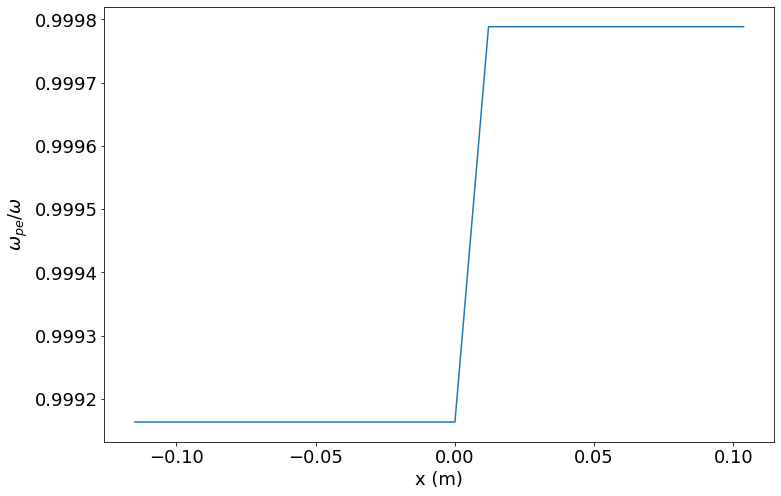

In [41]:
#Graficación ECRH
print(omega_pe)
graf_ecrh, ejes_ecrh = plt.subplots(figsize=(12,8)) #default (6,4)
ejes_ecrh.plot(np.transpose(r_1_radial),np.sqrt(omega_pe/omega_3))
ejes_ecrh.set_xlabel('x (m)', fontsize=18)
ejes_ecrh.set_ylabel(r'$\omega_{pe}/\omega$', fontsize=18)
ejes_ecrh.tick_params(axis = 'both', which = 'major', labelsize = 18 )
ejes_ecrh.yaxis.get_offset_text().set_fontsize(18) #tamaño de fuente del orden de magnitud
#ejes_d.set_xlim([np.amin(r_1_radial)-0.05, np.amax(r_1_radial)]+0.05)
#ejes_alfven.set_ylim([0, 1e6])
plt.savefig('ECRH_modo_O.jpg', facecolor='white', transparent=False)

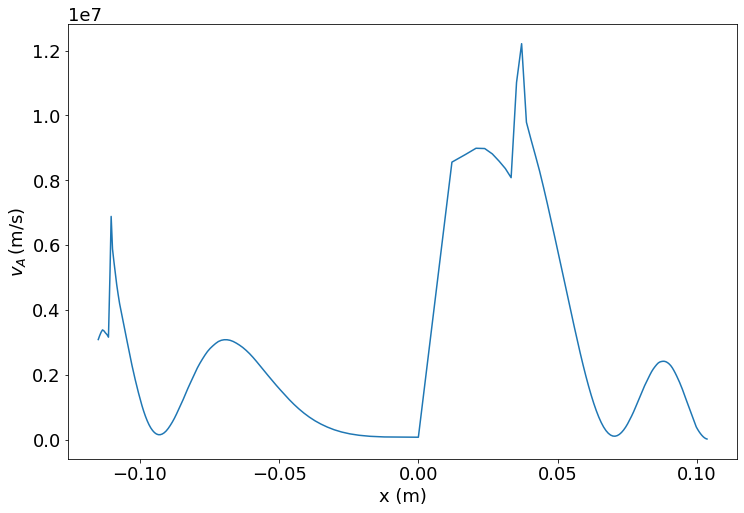

In [14]:
#Graficación alfvén
graf_alfven, ejes_alfven = plt.subplots(figsize=(12,8)) #default (6,4)
ejes_alfven.plot(np.transpose(r_1_radial),v_A)
ejes_alfven.set_xlabel('x (m)', fontsize=18)
ejes_alfven.set_ylabel(r'$v_A \,$(m/s)', fontsize=18)
ejes_alfven.tick_params(axis = 'both', which = 'major', labelsize = 18 )
ejes_alfven.yaxis.get_offset_text().set_fontsize(18) #tamaño de fuente del orden de magnitud
#ejes_d.set_xlim([np.amin(r_1_radial)-0.05, np.amax(r_1_radial)]+0.05)
#ejes_alfven.set_ylim([0, 1e6])
plt.savefig('alfven.jpg', facecolor='white', transparent=False)

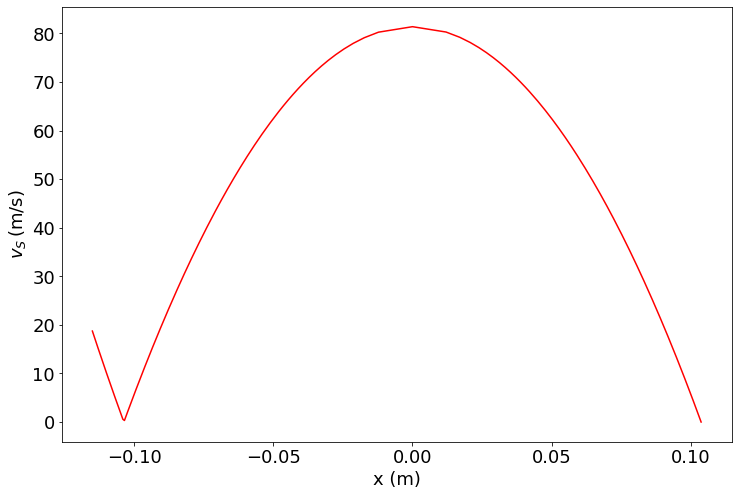

In [122]:
#Graficación sonido
graf_sonido, ejes_sonido = plt.subplots(figsize=(12,8)) #default (6,4)
ejes_sonido.plot(np.transpose(r_1_radial),v_S, c= 'r')
ejes_sonido.set_xlabel('x (m)', fontsize=18)
ejes_sonido.set_ylabel(r'$v_S \,$(m/s)', fontsize=18)
ejes_sonido.tick_params(axis = 'both', which = 'major', labelsize = 18 )
ejes_sonido.yaxis.get_offset_text().set_fontsize(18) #tamaño de fuente del orden de magnitud
#ejes_d.set_xlim([np.amin(r_1_radial)-0.05, np.amax(r_1_radial)]+0.05)
#ejes_alfven.set_ylim([0, 1e6])
plt.savefig('sonido.jpg', facecolor='white', transparent=False)

[-0.09714005 -0.08833966 -0.0372773  -0.03727293 -0.03726856  0.0070875
  0.05667656  0.05668094]


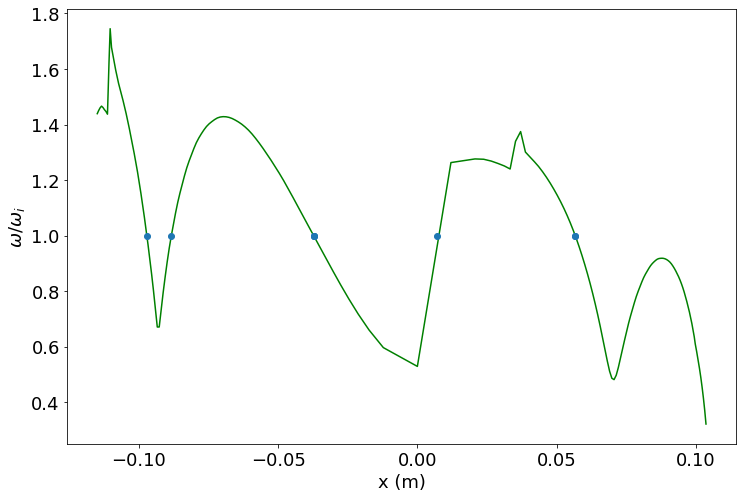

In [16]:
# Graficación omegas
#Constantes
m_i = constants.m_p
carga = constants.e
omega_de_trabajo = 2*pi*f #rad/s
#
omega_ion = carga*B_0_radial/m_i #rad/s
#
omega_alfven = np.sqrt(omega_1/omega_ion)
omega_magneto = np.sqrt(omega_2/omega_ion)
#
graf_sol, ejes_sol = plt.subplots(figsize=(12,8)) #default (6,4)
#ejes_sol.plot(np.transpose(r_1_radial),omega_alfven, c= 'g')
#ejes_sol.plot(np.transpose(r_1_radial),omega_magneto, c= 'orange')
ejes_sol.set_xlabel('x (m)', fontsize=18)
ejes_sol.set_ylabel(r'$\omega/\omega_i$', fontsize=18)
ejes_sol.tick_params(axis = 'both', which = 'major', labelsize = 18 )
ejes_sol.yaxis.get_offset_text().set_fontsize(18) #tamaño de fuente del orden de magnitud
#ejes_d.set_xlim([np.amin(r_1_radial)-0.05, np.amax(r_1_radial)]+0.05)
#ejes_alfven.set_ylim([0, 1e6])
#plt.savefig('sol_sonido.jpg', facecolor='white', transparent=False)
#omega = np.linspace(np.amin(omega_1), np.amax(omega_1), num = omega_1.shape[0])
#interpolación para encontrar donde omega = omega_ion
from scipy.interpolate import interp1d #interpolación para omega = omega_ion
f2 = interp1d(r_1_radial, omega_alfven, kind='cubic')
xnew = np.linspace(np.amin(r_1_radial), np.amax(r_1_radial), num=50000, endpoint=True)
ejes_sol.plot(np.transpose(r_1_radial),omega_alfven, c= 'g')
#print(np.amax(r_1_radial))
result = np.where(np.isclose(f2(xnew), 1.000000, 1.0e-4 ))
print(xnew[result[0]])
ejes_sol.plot(xnew[result[0]],f2(xnew)[result[0]], 'o')
#ejes_sol.plot(xnew,f2(xnew), c= 'r')
plt.savefig('sol_alfven.jpg', facecolor='white', transparent=False)

[0.10818066 0.13735758 0.17544044 0.21742448 0.26112386 0.30548966
 0.34992988 0.39516134 0.44067115 0.48514586 0.52879398 0.57141851
 0.61294807 0.65314899 0.69192196 0.73057334 0.7687228  0.80493659
 0.83935995 0.87153096 0.90146732 0.92923826 0.95477625 0.97880748
 1.00145065 1.02192149 1.0403696  1.05555394 1.06714767 1.0761185
 1.08261966 1.08623444 1.08704583 1.0853973  1.08224493 1.07539045
 1.06366342 1.04909783 1.03270716 1.01286509 0.98864369 0.96159917
 0.9337479  0.9025467  0.86607232 0.82678625 0.78695216 0.74428751
 0.69696966 0.64734896 0.59710768 0.54511437 0.4907498  0.43591769
 0.38261011 0.33178736 0.28603431 0.25094209 0.23301502 0.23816844
 0.26681851 0.31341799 0.37189088 0.43839226 0.51018689 0.58544135
 0.66280338 0.74161062 0.82141915 0.9017284  0.98231886 1.06306128
 1.14357816 1.22364448 1.30269303 1.38035022 1.45661546 1.53138651
 1.60449504 1.67611362 1.74624357 1.8155461  1.88309927 1.94833404
 2.01111354 2.06851412 2.12528426 2.18561881 2.44106447 2.31816

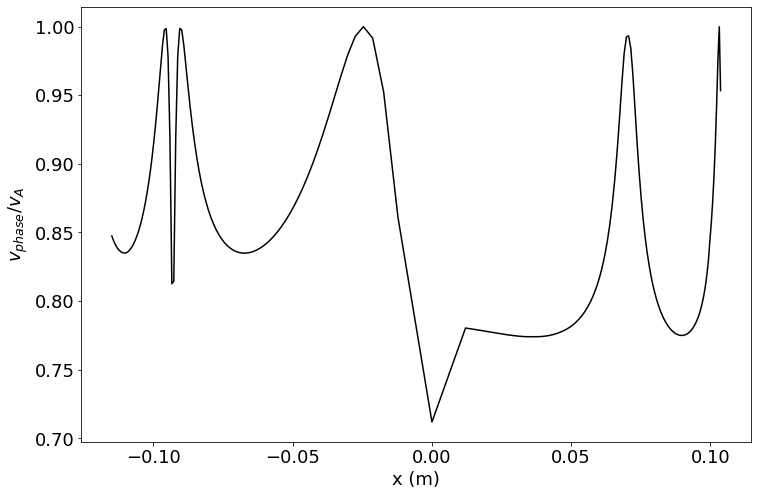

In [18]:
K = np.sqrt(np.power(K_par,2) + np.power(K_per,2))
K_radial = np.delete(np.append(K[:,15],K[:,1]), 0) # se elimina el índice repetido
n = (v_A*K_radial)/(omega_ion)
razon = (omega_1/K_radial)/(v_A)
graf_fase, ejes_fase = plt.subplots(figsize=(12,8)) #default (6,4)
#ejes_fase.plot(n,omega_alfven, 'o', c= 'r')
ejes_fase.plot(np.transpose(r_1_radial),razon, c= 'black')
ejes_fase.set_xlabel('x (m)', fontsize=18)
ejes_fase.set_ylabel(r'$v_{phase}/v_A \,$', fontsize=18)
ejes_fase.tick_params(axis = 'both', which = 'major', labelsize = 18 )
ejes_fase.yaxis.get_offset_text().set_fontsize(18) #tamaño de fuente del orden de magnitud
print(n)
#ejes_fase.set_xlim([0, 5])
#ejes_alfven.set_ylim([0, 1e6])
plt.savefig('v_fase_ingles.jpg', facecolor='white', transparent=False)